In [1]:
import time
import numpy as np

In [2]:
import torch
import torch.nn.functional as F
from torch import nn as nn, optim as optim
from torch.autograd import Variable

In [3]:
import torchvision as vis
import torchvision.transforms as transforms

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

### Image transformations and download MNIST dataset

In [9]:
mnist_transforms = transforms.Compose([transforms.ToTensor()])
mnist_train = vis.datasets.MNIST(root='./data/mnist', train=True, transform=mnist_transforms, download=True)
mnist_test = vis.datasets.MNIST(root='./data/mnist', train=False, transform=mnist_transforms, download=True)

Label: 5


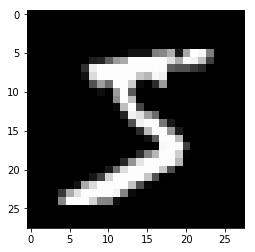

Label: 0


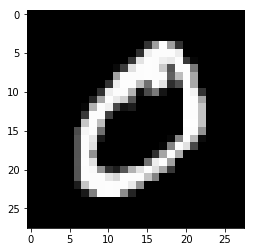

Label: 4


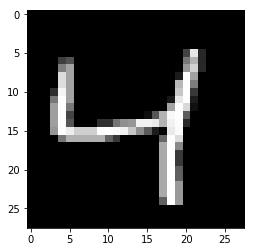

Label: 1


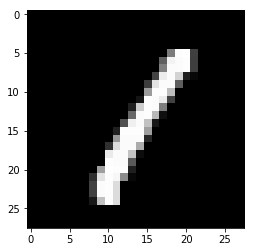

Label: 9


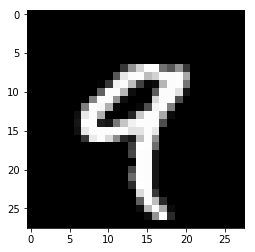

In [49]:
# Show first 5 training samples
for i in range(5):
    batch, label = mnist_train[i]
    image = batch[0].numpy()
    print('Label: %d' % label)
    plt.imshow(image, cmap='gray')
    plt.show()

In [1]:
test_idx = 1
test_input = Variable(mnist_train[test_idx][0].cuda()).unsqueeze(0)
test_output = model(test_input)
test_prediction, index = torch.max(test_output, 0)
plt.imshow(mnist_train[test_idx][0][0].numpy(), cmap='gray')
print('Prediction: %d' % int(index))

NameError: name 'Variable' is not defined

### Multi-threaded dataloaders

In [14]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=4)

In [5]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2
            nn.Conv2d(16, 32, 3, padding=1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            # Layer 3
            nn.Conv2d(32, 64, 3, padding=1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            # Layer 4
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.clf = nn.Linear(128, 10)
    
    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

In [6]:
cuda = torch.cuda.is_available()

In [7]:
model = MNISTClassifier()
if cuda:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [14]:
for epoch in range(50):
    # Train
    model.train()
    losses = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
    
    # Evaluate
    model.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            
        optimizer.zero_grad()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    print('+----- Epoch %d' % epoch)
    print('| Loss: %.3f' % np.mean(losses))
    print('| Accuracy: %.3f' % (100. * correct/total))
    print('+----- End Epoch %d' % epoch)

+----- Epoch 0
| Loss: 0.974
| Accuracy: 92.540
+----- End Epoch 0
+----- Epoch 1
| Loss: 0.341
| Accuracy: 95.630
+----- End Epoch 1
+----- Epoch 2
| Loss: 0.254
| Accuracy: 96.590
+----- End Epoch 2
+----- Epoch 3
| Loss: 0.210
| Accuracy: 97.010
+----- End Epoch 3
+----- Epoch 4
| Loss: 0.179
| Accuracy: 97.580
+----- End Epoch 4
+----- Epoch 5
| Loss: 0.162
| Accuracy: 97.670
+----- End Epoch 5
+----- Epoch 6
| Loss: 0.147
| Accuracy: 97.800
+----- End Epoch 6
+----- Epoch 7
| Loss: 0.138
| Accuracy: 98.180
+----- End Epoch 7
+----- Epoch 8
| Loss: 0.124
| Accuracy: 98.300
+----- End Epoch 8
+----- Epoch 9
| Loss: 0.119
| Accuracy: 98.370
+----- End Epoch 9
+----- Epoch 10
| Loss: 0.112
| Accuracy: 98.280
+----- End Epoch 10
+----- Epoch 11
| Loss: 0.106
| Accuracy: 98.570
+----- End Epoch 11
+----- Epoch 12
| Loss: 0.102
| Accuracy: 98.710
+----- End Epoch 12
+----- Epoch 13
| Loss: 0.099
| Accuracy: 98.540
+----- End Epoch 13
+----- Epoch 14
| Loss: 0.094
| Accuracy: 98.710
+----

In [16]:
torch.save(model.state_dict(), './models/4layer-mnist.pt')

In [8]:
model.load_state_dict(torch.load('./models/4layer-mnist.pt'))